### Gerekli Importlar

In [ ]:
!pip install transformers --exists-action i
!pip install pandas --exists-action i
!pip install matplotlib --exists-action i
!pip install fuzzywuzzy --exists-action i
!pip install python-Levenshtein --exists-action i

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.6 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
# transformers: Hugging Face kütüphanesi, NLP modelleri için.
# AutoModelForQuestionAnswering: Soru-cevap görevleri için önceden eğitilmiş model yükler.
# pipeline: NLP görevlerini hızlı bir şekilde gerçekleştirmek için kullanılır.

import pandas as pd
# pandas: Veri işleme ve analiz için kullanılan bir kütüphane.

import matplotlib.pyplot as plt
# matplotlib.pyplot: Veri görselleştirme için kullanılan bir kütüphane.

import json
# json: JSON formatındaki verileri işlemek (okuma/yazma) için kullanılan bir kütüphane.

from fuzzywuzzy import fuzz
# fuzzywuzzy: Metin benzerliğini karşılaştırmak için kullanılan bir kütüphane.

from collections import Counter
# collections.Counter: Elemanları sayarak frekans dağılımı oluşturan bir sınıf.

### Veri Dosyasını Yükleme

In [ ]:
# Veri dosyalarını yükleme için gerekli fonksiyonlar

def load_paragraph(filename):
    """
    Belirtilen dosyadan bir paragraf yükler.

    Args:
        filename (str): Yüklenecek paragraf dosyasının adı veya yolu.

    Returns:
        str: Dosyada bulunan paragraf metni.
    """
    with open(filename, "r", encoding="utf-8") as file:  # Dosyayı okuma modunda açıyoruz (UTF-8 karakter seti ile).
        return file.read()  # Dosyadaki tüm metni bir string olarak döndürüyoruz.

def load_questions_answers(filename):
    """
    Bir Excel dosyasından soru ve cevapları yükler.

    Args:
        filename (str): Yüklenecek Excel dosyasının adı veya yolu.

    Returns:
        tuple: İki liste döndürür:
            - questions (list): Excel'deki 'Soru' sütunundaki tüm sorular.
            - answers (list): Excel'deki 'Cevap' sütunundaki tüm cevaplar.
    """
    df = pd.read_excel(filename)  # Excel dosyasını bir pandas DataFrame olarak yükler.
    questions = df['Soru'].tolist()  # 'Soru' sütunundaki verileri bir listeye dönüştürür.
    answers = df['Cevap'].tolist()  # 'Cevap' sütunundaki verileri bir listeye dönüştürür.
    return questions, answers  # Sorular ve cevapları döndürür.

# Paragraf ve soru-cevapları yükleme

context = load_paragraph("paragraf.txt")
# 'paragraf.txt' dosyasını yükleyerek, paragraf metnini 'context' değişkenine atıyoruz.

questions, correct_answers = load_questions_answers("soru_cevap.xlsx")
# 'soru_cevap.xlsx' dosyasındaki soruları ve cevapları yükleyip,
# sırasıyla 'questions' ve 'correct_answers' listelerine atıyoruz.

### Gerekli Fonksiyonların tanınmlanması

In [ ]:
# Metin normalize edici
def normalize_text(text):
    """
    Metni normalize eder. Küçük harfe çevirir, baştaki ve sondaki boşlukları kaldırır,
    belirli kelimeleri ('yılında') ve noktalama işaretlerini kaldırır.

    Args:
        text (str): Normalize edilecek metin.

    Returns:
        str: Normalleştirilmiş metin.
    """
    return text.lower().strip().replace(".", "").replace(",", "").replace("yılında", "").replace("yılı", "").replace("yıl", "")  # Metni düzenler.

# Esnek doğruluk hesaplama fonksiyonu
def calculate_fuzzy_accuracy(model_answers, correct_answers, threshold=51):
    """
    Model yanıtlarının, doğru yanıtlarla esnek (fuzzy) eşleşmesine göre doğruluk oranını hesaplar.

    Args:
        model_answers (dict): Sorular ve modelin ürettiği cevapları içeren bir sözlük.
        correct_answers (list): Doğru cevapları içeren bir liste.
        threshold (int): Eşleşme oranı için eşik değeri (varsayılan: 51).

    Returns:
        float: Doğruluk oranı yüzdesi.
    """
    correct = 0  # Doğru cevap sayısını tutar.
    total = len(correct_answers)  # Toplam cevap sayısını hesaplar.

    for question, correct_answer in zip(questions, correct_answers):  # Soruları ve doğru cevapları döngüye alır.
        model_answer = model_answers.get(question, "")  # Sorunun model cevabını alır.
        similarity_score = fuzz.ratio(normalize_text(model_answer), normalize_text(correct_answer))
        # Model ve doğru cevap arasında benzerlik skorunu hesaplar.
        if similarity_score >= threshold:  # Eğer benzerlik skoru eşik değerden büyükse doğru kabul eder.
            correct += 1

    return (correct / total) * 100 if total > 0 else 0  # Toplam cevap sayısına göre doğruluk oranını yüzdelik döndürür.

def calculate_retrieval_accuracy(context, correct_answers):
    """
    Doğru yanıtların verilen paragraf içinde bulunma oranını hesaplar.

    Args:
        context (str): Paragraf metni.
        correct_answers (list): Doğru cevapların listesi.

    Returns:
        float: Doğru yanıtların bulunma oranı yüzdesi.
    """
    retrieval_correct = 0  # Paragrafta bulunan doğru yanıtların sayısını tutar.
    total = len(correct_answers)  # Toplam doğru cevap sayısını hesaplar.

    for correct_answer in correct_answers:  # Doğru cevapları döngüye alır.
        if normalize_text(correct_answer) in normalize_text(context):
            # Doğru cevabın normalize edilmiş hali paragrafta varsa sayıyı artırır.
            retrieval_correct += 1

    return (retrieval_correct / total) * 100 if total > 0 else 0  # Oranı yüzdelik döndürür.

def calculate_ragas_score(retrieval_accuracy, generation_accuracy):
    """
    RAGAS skorunu hesaplar. Retrieval ve Generation doğruluk oranlarının ortalamasını alır.

    Args:
        retrieval_accuracy (float): Paragraftan geri çağırma doğruluk oranı.
        generation_accuracy (float): Model tarafından üretilen cevapların doğruluk oranı.

    Returns:
        float: RAGAS skoru.
    """
    return (retrieval_accuracy + generation_accuracy) / 2  # İki doğruluk oranının ortalamasını döndürür.

# Ensemble yöntemleri
def majority_voting(answers):
    """
    Birden fazla model cevabının çoğunluk oylamasına göre en sık geçen cevabı döndürür.

    Args:
        answers (list): Modellerin ürettiği cevapların listesi.

    Returns:
        str: En sık geçen cevap.
    """
    return Counter(answers).most_common(1)[0][0]  # En sık geçen cevabı bulur ve döndürür.


### Model ve Tokenizer

In [ ]:
# Modeller ve tokenizer'lar
models = [
    ("savasy/bert-base-turkish-squad", "savasy/bert-base-turkish-squad"),
    ("ProfHuseyin/bert-turkish-fine-tuning-question-answering", "ProfHuseyin/bert-turkish-fine-tuning-question-answering"),
    ("kuzgunlar/electra-turkish-qa", "kuzgunlar/electra-turkish-qa"),
    ("Izzet/qa_ytu_bert-base-turkish", "Izzet/qa_ytu_bert-base-turkish"),
    ("Izzet/qa_ytu_electra-base-turkish", "Izzet/qa_ytu_electra-base-turkish"),
    ("muratsimsek003/WikiRAG-turkish-finetuned", "muratsimsek003/WikiRAG-turkish-finetuned"),
    ("kaixkhazaki/turkish-question-answering", "kaixkhazaki/turkish-question-answering"),
    ("sshleifer/tiny-distilbert-base-cased-distilled-squad", "sshleifer/tiny-distilbert-base-cased-distilled-squad"),
    ("google/mt5-small", "google/mt5-small")
]

### Q-A pipeline oluşturma

In [ ]:
# QA pipeline oluşturma (Question Answering modellerini hazırlama)

nlp_models = []  # NLP modellerinin adlarını ve pipeline nesnelerini saklamak için bir liste oluşturuyoruz.

for model_name, model_path in models:
    # 'models' listesi içinde dolaşarak her modelin adını ve yolunu alıyoruz.

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    # Modelin tokenizer'ını, modelin bulunduğu dosya yolundan yükler.

    model = AutoModelForQuestionAnswering.from_pretrained(model_path)
    # Modelin kendisini, modelin bulunduğu dosya yolundan yükler.

    nlp = pipeline("question-answering", model=model, tokenizer=tokenizer, device=0)
    # Question Answering görevini gerçekleştiren bir pipeline oluşturuyoruz.
    # GPU kullanımı için 'device=0' parametresini belirtiyoruz.

    nlp_models.append((model_name, nlp))
    # Model adını ve oluşturulan pipeline'ı bir tuple olarak listeye ekliyoruz.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/485 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at savasy/bert-base-turkish-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of the model checkpoint at ProfHuseyin/bert-turkish-fine-tuning-question-answering were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/126 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/786 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/735M [00:00<?, ?B/s]

Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/755k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/886 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/755k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/245k [00:00<?, ?B/s]

Device set to use cuda:0


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

Some weights of MT5ForQuestionAnswering were not initialized from the model checkpoint at google/mt5-small and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


### Model Çalıştırma ve Sonuçları Kaydetme

In [ ]:
# Modelleri çalıştırma ve sonuç hesaplama

results = {}  # Her modelin doğruluk sonuçlarını saklamak için bir sözlük.
ragas_scores = {}  # Her modelin RAGAS skorlarını saklamak için bir sözlük.
all_model_answers = {}  # Her modelin verdiği cevapları saklamak için bir sözlük.

ensemble_answers = {question: [] for question in questions}
# Ensemble yöntemleri için, her soru için verilen cevapları bir listeye toplamak için bir sözlük oluşturulur.

for model_name, nlp in nlp_models:
    # Tüm modelleri sırayla çalıştırmak için bir döngü başlatıyoruz.

    model_answers = {}  # Modelin verdiği cevapları tutmak için bir sözlük.
    print(f"\n--- {model_name} Modeli İçin Yanıtlar ---\n")
    # Hangi modelin çalıştığını göstermek için bir başlık yazdırılır.

    for question in questions:
        # Her bir soru için modeli çalıştırıyoruz.

        result = nlp(question=question, context=context)
        # Modeli, verilen soru ve paragraf bağlamında çalıştırıyoruz.

        answer = result.get('answer', "")
        # Modelin cevabını alıyoruz. Eğer cevap bulunamazsa boş bir string döner.

        model_answers[question] = answer
        # Soruyu ve modelin cevabını bir sözlüğe ekliyoruz.

        ensemble_answers[question].append(answer)
        # Ensemble yöntemleri için cevabı kaydediyoruz.

    # Cevapları saklama
    all_model_answers[model_name] = model_answers  # Modelin tüm cevaplarını saklıyoruz.

    # Doğruluk hesaplamaları
    generation_accuracy = calculate_fuzzy_accuracy(model_answers, correct_answers, threshold=51)
    # Fuzzy doğruluk oranını hesaplıyoruz.

    retrieval_accuracy = calculate_retrieval_accuracy(context, correct_answers)
    # Geri çağırma doğruluk oranını hesaplıyoruz.

    ragas_score = calculate_ragas_score(retrieval_accuracy, generation_accuracy)
    # RAGAS skorunu hesaplıyoruz.

    results[model_name] = generation_accuracy  # Modelin doğruluk oranını kaydediyoruz.
    ragas_scores[model_name] = ragas_score  # Modelin RAGAS skorunu kaydediyoruz.

# Ensemble hesaplama
ensemble_results = {}  # Ensemble sonuçlarını saklamak için bir sözlük.
ensemble_ragas_scores = {}  # Ensemble RAGAS skorlarını saklamak için bir sözlük.
ensemble_accuracies = {}  # Ensemble doğruluk oranlarını saklayacak bir sözlük.

for question, answers in ensemble_answers.items():
    # Ensemble yöntemleri için her sorunun cevaplarını işliyoruz.

    majority_answer = majority_voting(answers)
    # Majority Voting yöntemiyle en sık geçen cevabı belirliyoruz.

    ensemble_results[question] = {
        "Majority Voting": majority_answer
        # Ensemble sonuçlarına Majority Voting cevabını ekliyoruz.
    }

# Ensemble doğruluk hesaplamaları
for method in ["Majority Voting"]:
    # Kullanılan ensemble yöntemleri üzerinde doğruluk hesaplamaları yapıyoruz.

    method_answers = {q: ans[method] for q, ans in ensemble_results.items()}
    # Her yöntem için cevapları topluyoruz.

    generation_accuracy = calculate_fuzzy_accuracy(method_answers, correct_answers, threshold=51)
    # Fuzzy doğruluk oranını hesaplıyoruz.

    # Ensemble doğruluk oranını kaydediyoruz.
    ensemble_accuracies[method] = generation_accuracy

    retrieval_accuracy = calculate_retrieval_accuracy(context, correct_answers)
    # Geri çağırma doğruluk oranını hesaplıyoruz.

    ragas_score = calculate_ragas_score(retrieval_accuracy, generation_accuracy)
    # RAGAS skorunu hesaplıyoruz.

    ensemble_ragas_scores[method] = ragas_score
    # Ensemble yöntemi için RAGAS skorunu kaydediyoruz.

# Cevapları JSON dosyasına kaydetme
with open("answers.json", "w", encoding="utf-8") as file:
    # Tüm model cevaplarını bir JSON dosyasına kaydediyoruz.
    json.dump(all_model_answers, file, ensure_ascii=False, indent=4)

with open("ensemble_answers.json", "w", encoding="utf-8") as file:
    # Ensemble yöntemlerine göre hesaplanan cevapları bir JSON dosyasına kaydediyoruz.
    json.dump(ensemble_results, file, ensure_ascii=False, indent=4)



--- savasy/bert-base-turkish-squad Modeli İçin Yanıtlar ---


--- ProfHuseyin/bert-turkish-fine-tuning-question-answering Modeli İçin Yanıtlar ---


--- kuzgunlar/electra-turkish-qa Modeli İçin Yanıtlar ---


--- Izzet/qa_ytu_bert-base-turkish Modeli İçin Yanıtlar ---


--- Izzet/qa_ytu_electra-base-turkish Modeli İçin Yanıtlar ---


--- muratsimsek003/WikiRAG-turkish-finetuned Modeli İçin Yanıtlar ---


--- kaixkhazaki/turkish-question-answering Modeli İçin Yanıtlar ---


--- sshleifer/tiny-distilbert-base-cased-distilled-squad Modeli İçin Yanıtlar ---


--- google/mt5-small Modeli İçin Yanıtlar ---



### Sonuçları Yazdırma ve Görselleştirme


Model Performans Sonuçları:
savasy/bert-base-turkish-squad: 38.00%
ProfHuseyin/bert-turkish-fine-tuning-question-answering: 38.00%
kuzgunlar/electra-turkish-qa: 58.00%
Izzet/qa_ytu_bert-base-turkish: 14.00%
Izzet/qa_ytu_electra-base-turkish: 8.00%
muratsimsek003/WikiRAG-turkish-finetuned: 0.00%
kaixkhazaki/turkish-question-answering: 34.00%
sshleifer/tiny-distilbert-base-cased-distilled-squad: 0.00%
google/mt5-small: 0.00%

Model RAGAS Skorları:
savasy/bert-base-turkish-squad: 43.00%
ProfHuseyin/bert-turkish-fine-tuning-question-answering: 43.00%
kuzgunlar/electra-turkish-qa: 53.00%
Izzet/qa_ytu_bert-base-turkish: 31.00%
Izzet/qa_ytu_electra-base-turkish: 28.00%
muratsimsek003/WikiRAG-turkish-finetuned: 24.00%
kaixkhazaki/turkish-question-answering: 41.00%
sshleifer/tiny-distilbert-base-cased-distilled-squad: 24.00%
google/mt5-small: 24.00%

Ensemble RAGAS Skorları:
Majority Voting: 44.00%

Ensemble Doğruluk Oranları:
Majority Voting: 40.00%


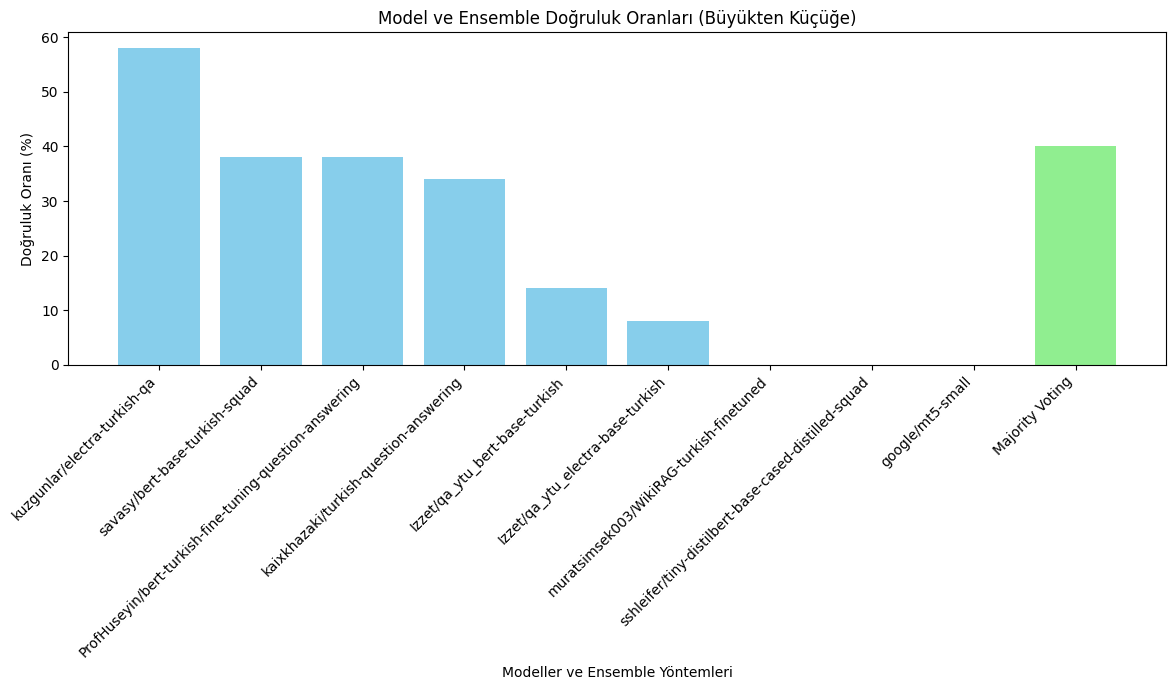

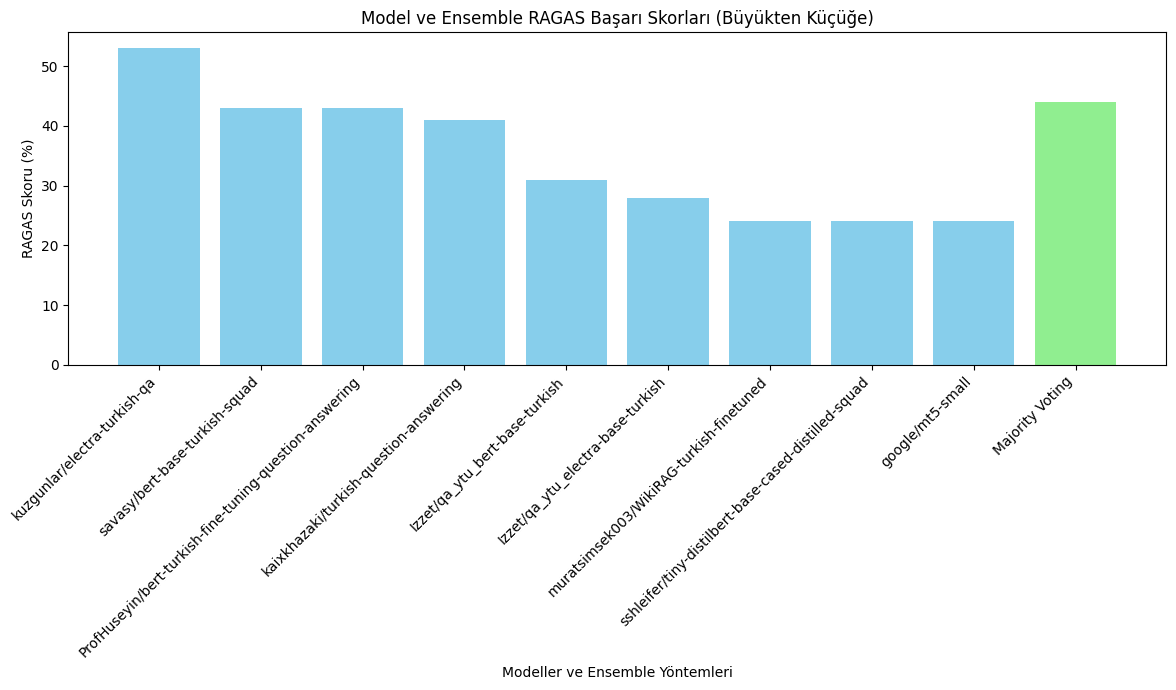

In [ ]:
# Performans sonuçlarını yazdırma
print("\nModel Performans Sonuçları:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.2f}%")

print("\nModel RAGAS Skorları:")
for model_name, ragas_score in ragas_scores.items():
    print(f"{model_name}: {ragas_score:.2f}%")

print("\nEnsemble RAGAS Skorları:")
for method, score in ensemble_ragas_scores.items():
    print(f"{method}: {score:.2f}%")

print("\nEnsemble Doğruluk Oranları:")
for method, accuracy in ensemble_accuracies.items():
    print(f"{method}: {accuracy:.2f}%")

# Performans sonuçlarını görselleştirme
sorted_performance = sorted(results.items(), key=lambda x: x[1], reverse=True)
ensemble_accuracy_sorted = sorted(ensemble_accuracies.items(), key=lambda x: x[1], reverse=True)
# Model performanslarını ve ensemble doğruluk oranlarını büyükten küçüğe sıralıyoruz.

# Birleştirilmiş doğruluk sonuçlarını görselleştirme
combined_performance = sorted_performance + ensemble_accuracy_sorted
names, scores = zip(*combined_performance)
colors = ['skyblue'] * len(sorted_performance) + ['lightgreen'] * len(ensemble_accuracy_sorted)

fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(names, scores, color=colors)
ax.set_title("Model ve Ensemble Doğruluk Oranları (Büyükten Küçüğe)")
ax.set_xlabel("Modeller ve Ensemble Yöntemleri")
ax.set_ylabel("Doğruluk Oranı (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# RAGAS skorlarını görselleştirme
sorted_ragas = sorted(ragas_scores.items(), key=lambda x: x[1], reverse=True)
sorted_ensemble_ragas = sorted(ensemble_ragas_scores.items(), key=lambda x: x[1], reverse=True)
all_scores = sorted_ragas + sorted_ensemble_ragas

fig, ax = plt.subplots(figsize=(12, 7))
names, scores = zip(*all_scores)
colors = ['skyblue'] * len(sorted_ragas) + ['lightgreen'] * len(sorted_ensemble_ragas)

ax.bar(names, scores, color=colors)
ax.set_title("Model ve Ensemble RAGAS Başarı Skorları (Büyükten Küçüğe)")
ax.set_xlabel("Modeller ve Ensemble Yöntemleri")
ax.set_ylabel("RAGAS Skoru (%)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
